In [1]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the dataset
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df


# change label names to its original names
def change_label_names(df, column_name):
    index = {'melanoma': 'Melanoma', 'naevus': 'Naevus'}


    df[column_name] = df[column_name].replace(index)

In [3]:
# loading the data
data_dir = r"E:\complete_mednode_dataset"
df = loading_the_data(data_dir)

change_label_names(df, 'labels')

df

filepaths    labels
0         E:\complete_mednode_dataset\melanoma\1.jpg  Melanoma
1        E:\complete_mednode_dataset\melanoma\10.jpg  Melanoma
2       E:\complete_mednode_dataset\melanoma\100.jpg  Melanoma
3      E:\complete_mednode_dataset\melanoma\1000.jpg  Melanoma
4      E:\complete_mednode_dataset\melanoma\1001.jpg  Melanoma
...                                              ...       ...
12042     E:\complete_mednode_dataset\naevus\995.jpg    Naevus
12043     E:\complete_mednode_dataset\naevus\996.jpg    Naevus
12044     E:\complete_mednode_dataset\naevus\997.jpg    Naevus
12045     E:\complete_mednode_dataset\naevus\998.jpg    Naevus
12046     E:\complete_mednode_dataset\naevus\999.jpg    Naevus

[12047 rows x 2 columns]

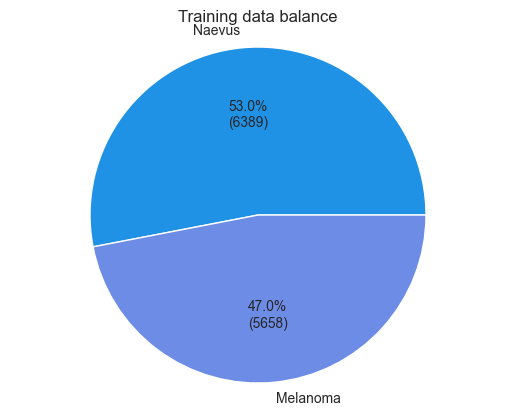

In [4]:
data_balance = df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

In [5]:
# data --> 80% train data && 20% (test, val)
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

# test data --> 10% train data && 10% (test, val)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [6]:
# crobed image size
batch_size = 32
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 9637 validated image filenames belonging to 2 classes.
Found 1205 validated image filenames belonging to 2 classes.
Found 1205 validated image filenames belonging to 2 classes.


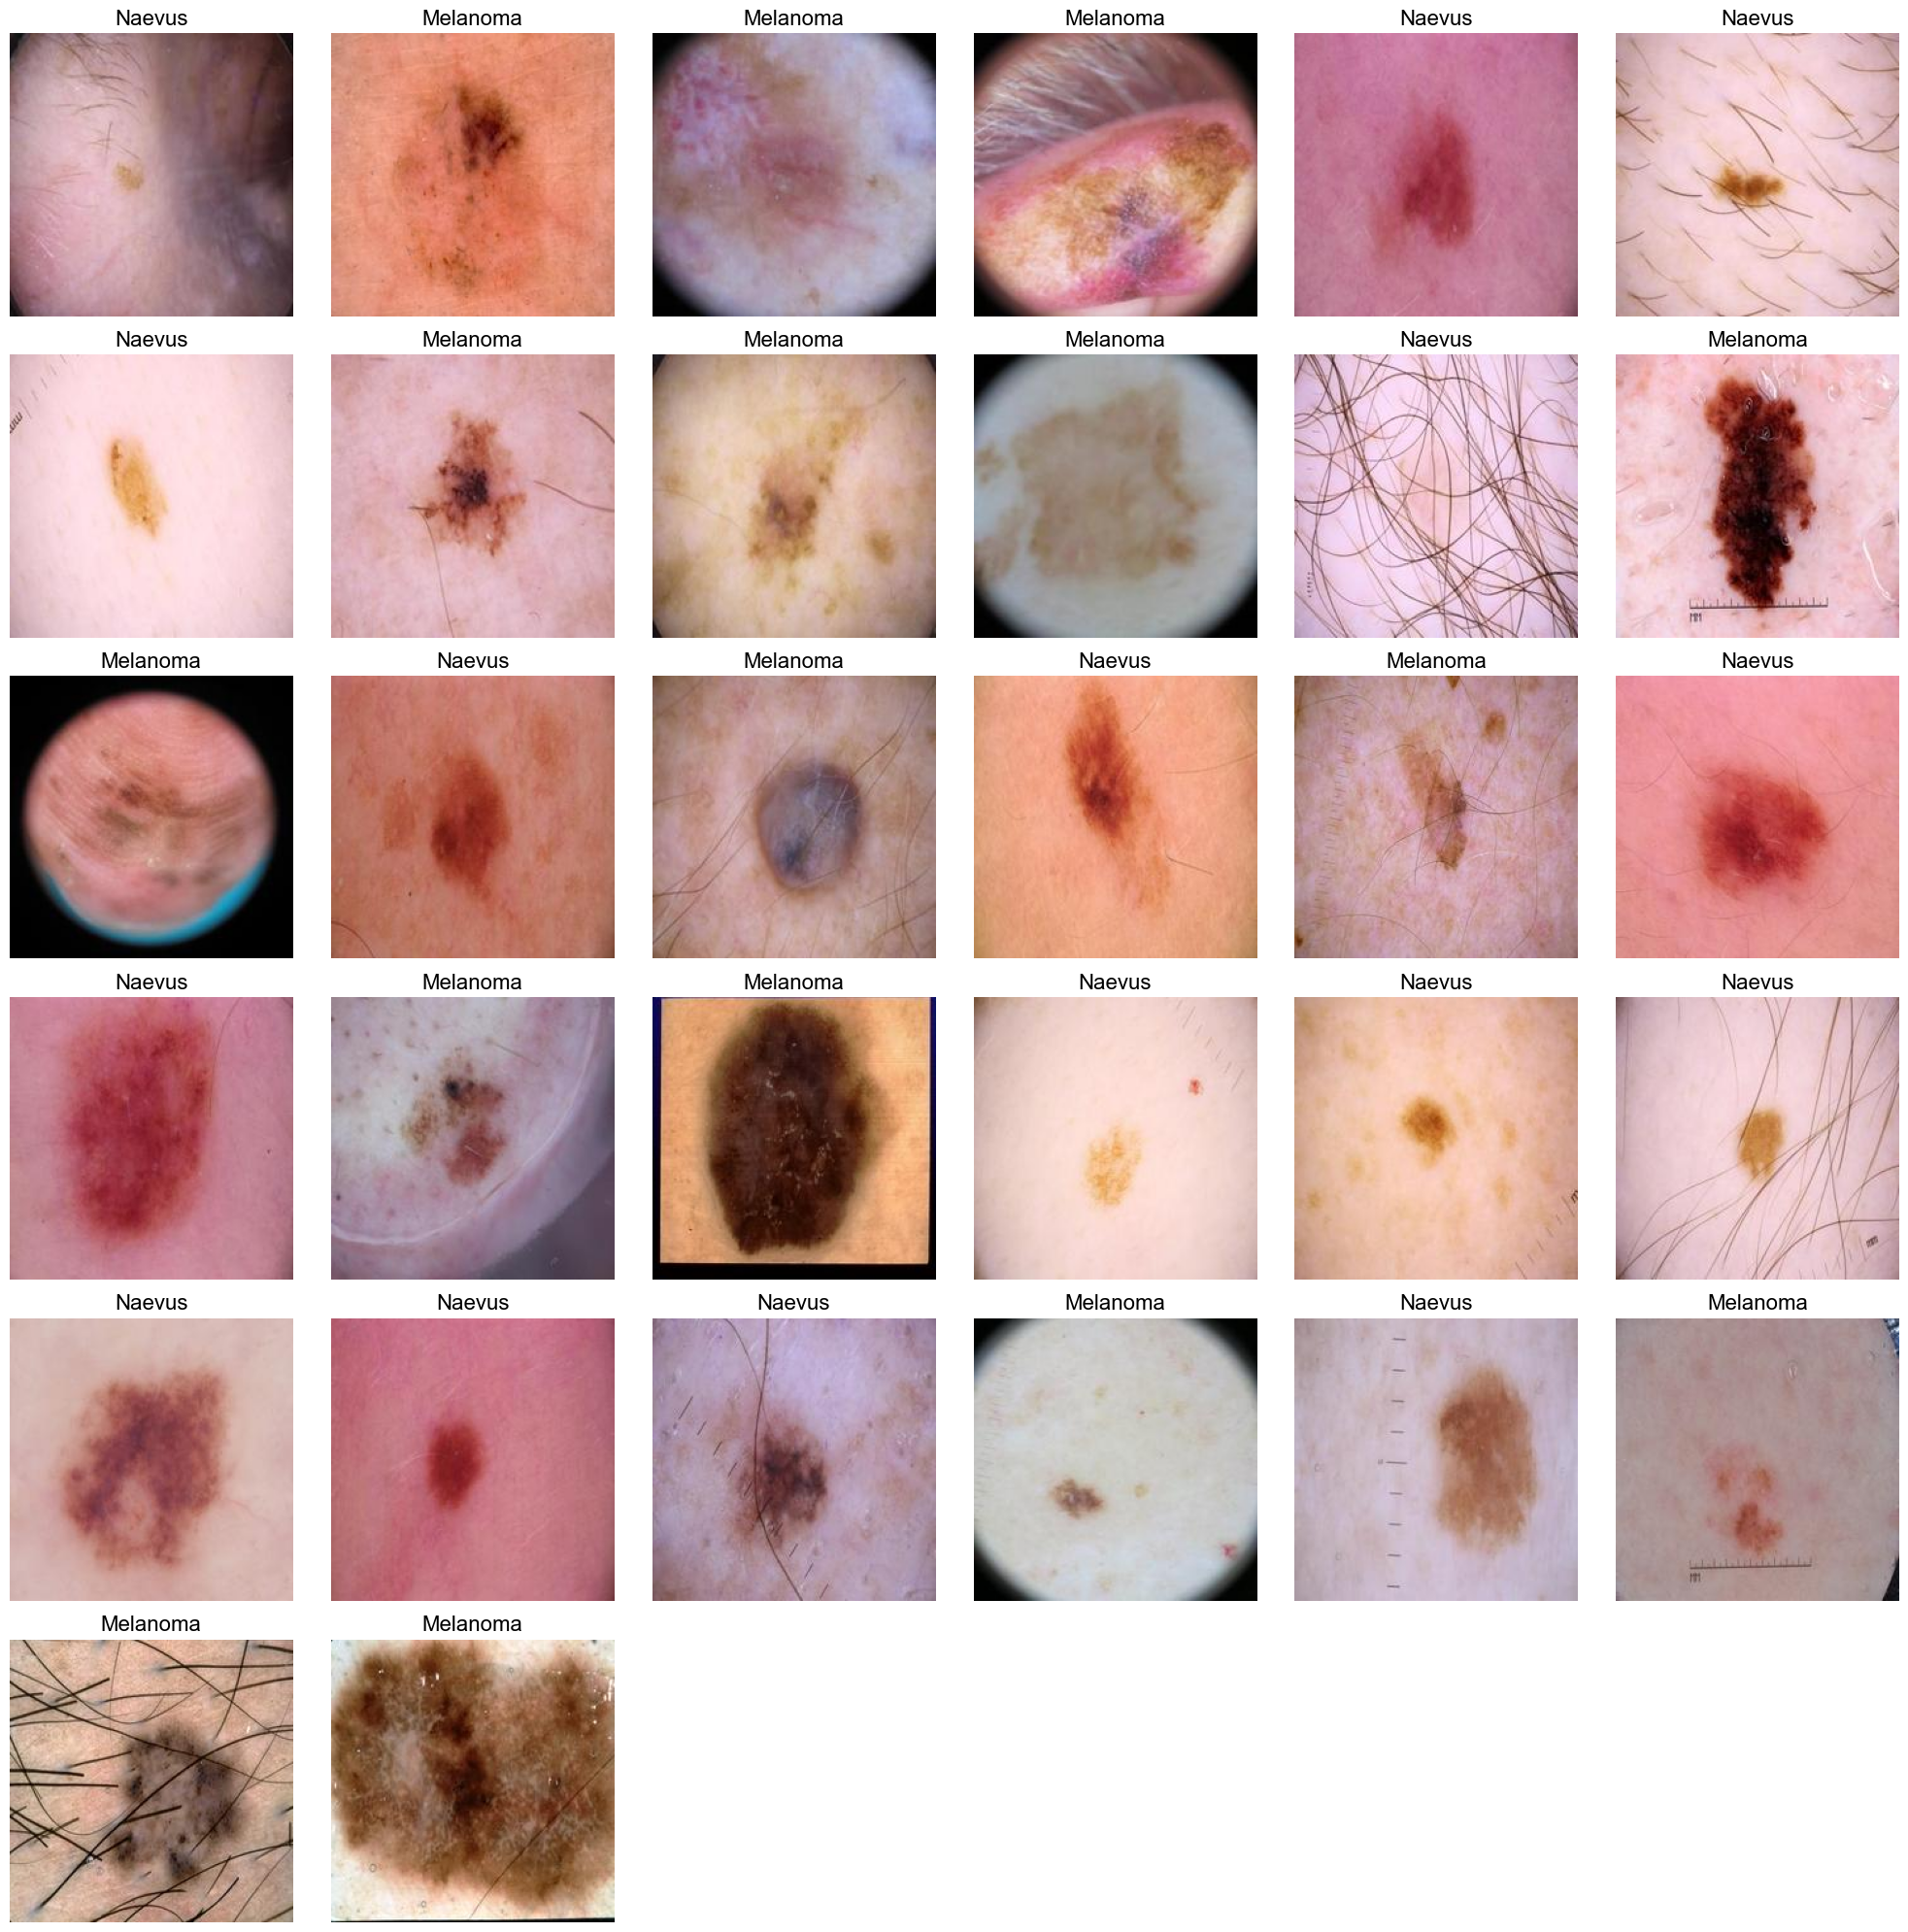

In [7]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(6, 6, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
# Load the MobileNetV2 model pre-trained on ImageNet and add custom layers on top
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

# Compile the model with the corrected parameter
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Train the model
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=valid_gen,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 1020s 3s/step - accuracy: 0.8008 - loss: 0.4311 - val_accuracy: 0.5768 - val_loss: 2.9603 - learning_rate: 1.0000e-04
Epoch 2/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 488s 2s/step - accuracy: 0.9095 - loss: 0.2207 - val_accuracy: 0.6266 - val_loss: 2.3139 - learning_rate: 1.0000e-04
Epoch 3/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 484s 2s/step - accuracy: 0.9373 - loss: 0.1508 - val_accuracy: 0.7328 - val_loss: 0.9349 - learning_rate: 1.0000e-04
Epoch 4/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 478s 2s/step - accuracy: 0.9672 - loss: 0.0909 - val_accuracy: 0.7344 - val_loss: 1.5436 - learning_rate: 1.0000e-04
Epoch 5/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 478s 2s/step - accuracy: 0.9702 - loss: 0.0779 - val_accuracy: 0.6772 - val_loss: 2.8272 - learning_rate: 1.0000e-04
Epoch 6/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 484s 2s/step - accuracy: 0.9792 - loss: 0.0579 - val_accuracy: 0.7685 - val_loss: 1.4221 - learning_rate: 1.0000e-04
Epoch 7/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 450s 1s/step - ac

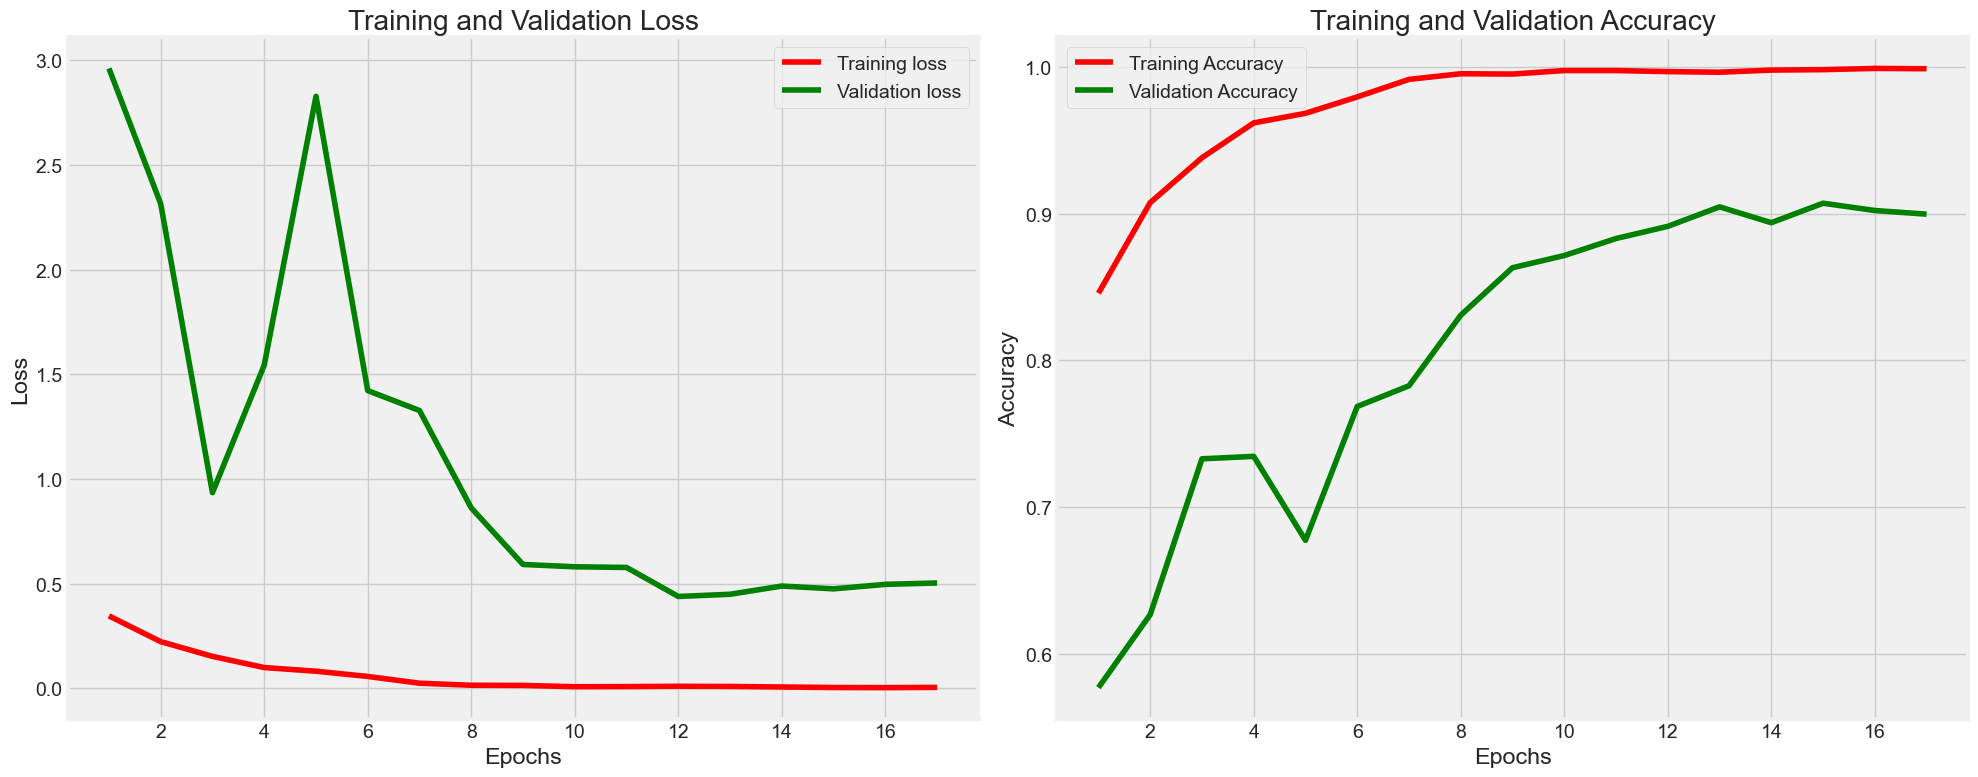

302/302 ━━━━━━━━━━━━━━━━━━━━ 118s 390ms/step - accuracy: 0.9990 - loss: 0.0046
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 393ms/step - accuracy: 0.8962 - loss: 0.4490
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 532ms/step - accuracy: 0.8998 - loss: 0.4912
Train Loss:  0.003930322825908661
Train Accuracy:  0.9991698861122131
--------------------
Validation Loss:  0.43920037150382996
Validation Accuracy:  0.891286313533783
--------------------
Test Loss:  0.4700574278831482
Test Accuracy:  0.8954356908798218


In [10]:
# Displaying the model performance
def model_performance(history):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(tr_acc) + 1)

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

model_performance(history)

# Evaluate the model on test data
def model_evaluation(model, train_gen, valid_gen, test_gen):
    train_score = model.evaluate(train_gen, verbose=1)
    valid_score = model.evaluate(valid_gen, verbose=1)
    test_score = model.evaluate(test_gen, verbose=1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

model_evaluation(model, train_gen, valid_gen, test_gen)


38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 617ms/step


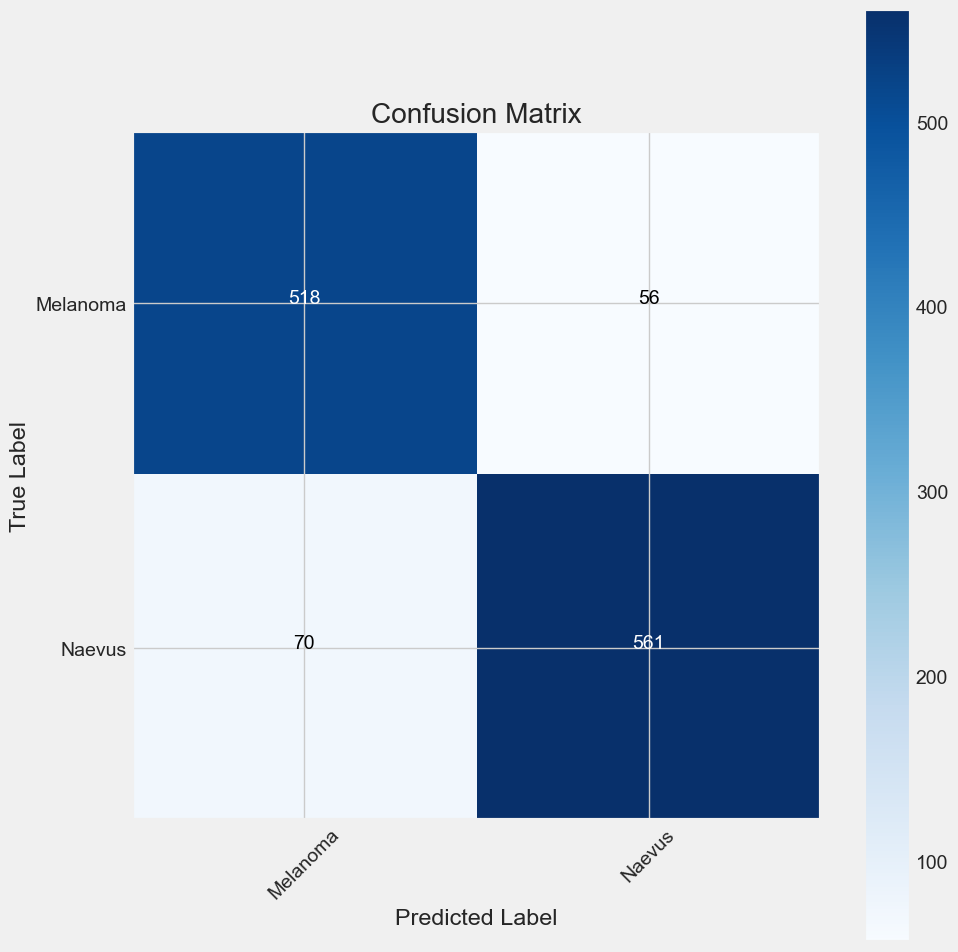

In [11]:
# Get Predictions
def get_pred(model, test_gen):
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)
    return y_pred

y_pred = get_pred(model, test_gen)

# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred):
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())

    cm = confusion_matrix(test_gen.classes, y_pred)
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(test_gen, y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


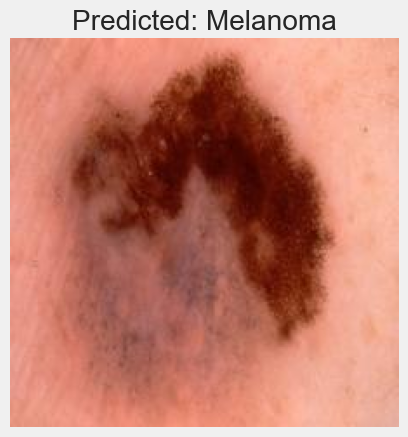

The predicted class for the image E:\complete_mednode_dataset\melanoma\739.jpg is: Melanoma


In [12]:
import os
import random
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def predict_random_image_from_dataset(df, model, classes, img_size=(224, 224)):
    # Select a random image path from the dataframe
    random_image_path = df.sample(n=1)['filepaths'].values[0]

    # Load the image
    img = image.load_img(random_image_path, target_size=img_size)

    # Preprocess the image
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image to [0, 1]

    # Make a prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    class_name = classes[predicted_class]

    # Display the image with predicted class
    plt.imshow(img)
    plt.title(f"Predicted: {class_name}")
    plt.axis('off')
    plt.show()

    return random_image_path, class_name

# Example usage
random_image_path, predicted_class = predict_random_image_from_dataset(df, model, classes)
print(f"The predicted class for the image {random_image_path} is: {predicted_class}")
